In [12]:
# LIBRARIES
import pandas as pd
import nltk
from nltk.corpus import stopwords
import sklearn
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.losses import Loss
import pickle
import warnings
warnings.simplefilter("ignore")

In [2]:
# Import TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# Additional libraries for text preprocessing and feature engineering
import re
from nltk.corpus import stopwords
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
import gensim.downloader as api

In [4]:
# READ THE FILE INTO A DATAFRAME
df = pd.read_csv("../../Fake review detection dataset/Yelp Dataset Reduced.csv")
#df = df[:5000]

In [5]:
# REMOVE MAX
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
df.head()

,ID,USER_ID,PRODUCT_ID,RATING,DATE,LABEL,REVIEW_TEXT,AVERAGE_RATING,RATING_DEVIATION,TOTAL_PRODUCT_REVIEWS,REVIEW_LENGTH,RATING_CATEGORY,SINGLE_RATING_CATEGORY,REVIEW_COUNT_DATE,SAME_DATE_MULTIPLE_REVIEWS,MAX_USER_REVIEWS_DAY,TIMESTAMP_DIFFERENCE,AVERAGE_USER_REVIEW_LENGTH,TOTAL_USER_REVIEWS,PERCENTAGE_POSITIVE_REVIEWS,RATIO_POSITIVE_NEGATIVE
0,144828,66563,416,4,10-12-2014,-1,Great.....,3.767293,0.232707,2183,10,1,1,1,0,2,0 days,11.500000,2,100.0,6.157377
1,157607,74755,449,4,26-03-2013,1,My family and I had Bubby's brunch on a Saturd...,3.396552,0.603448,812,824,1,1,2,0,2,1723 days,724.666667,12,100.0,3.121827
2,70401,49165,237,3,11-10-2011,1,"I really like this place, but they need to get...",3.799003,0.799003,602,314,1,1,2,0,1,0 days,314.000000,1,100.0,6.082353
3,124810,75653,363,5,14-01-2014,1,This is one of my favorite places in the US. A...,3.990361,1.009639,2075,280,1,1,1,0,1,0 days,280.000000,1,100.0,9.121951
4,42068,32402,100,4,02-12-2014,1,Make sure you go with a small group of friends...,3.951812,0.048188,2677,478,1,1,2,0,1,398 days,255.666667,3,100.0,8.734545


In [7]:
# Define text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation and special characters
    text = re.sub(r"\s+", " ", text)  # Remove extra whitespace
    stop_words = set(stopwords.words("english"))
    text = " ".join([word for word in text.split() if word not in stop_words])    
    return text

df["REVIEW_TEXT"] = df["REVIEW_TEXT"].apply(preprocess_text)
text_data = df["REVIEW_TEXT"]
text_data_list = text_data.tolist()

In [8]:
text_features = df['REVIEW_TEXT']
numerical_features = df.drop(['ID', 'USER_ID', 'PRODUCT_ID', 'DATE', 'REVIEW_TEXT', 'LABEL'], axis=1)
labels = df['LABEL']

In [9]:
# Find maximum length
max_length = max(len(text) for text in text_features)

print("Maximum length:", max_length)

Maximum length: 3651


In [10]:
# Convert labels from 1 to 0 and -1 to 1
labels_encoded = labels.replace({1: 0, -1: 1})

In [13]:
# Use TF-IDF vectorizer to convert text into numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["REVIEW_TEXT"])
y = labels_encoded 

In [14]:
# ADD PADDING TO ENSURE CONSISTENT SEQUENCE LENGTH
vocab_size = len(vectorizer.vocabulary_)
max_len = 200

#num_samples = X.getnnz(axis=1).sum()  # Assuming sequences are stored in rows

def get_sparse_sequence_lengths(X):
  lengths = []
  for row in X:
    # Iterate through elements and count non-zero values
    length = row.getnnz()
    lengths.append(length)
  return lengths

from scipy.sparse import csr_matrix  # Assuming your sparse matrix is in CSR format

# Get sequence lengths (use either method from step 1)
sequence_lengths = get_sparse_sequence_lengths(X)

# Convert sparse matrix to CSR format (if needed)
X_csr = csr_matrix(X)

# Pad the sequences (replace 'post' with 'pre' for padding at the beginning)
X = pad_sequences(X_csr.toarray(), padding='post', maxlen=max_len)

#X = pad_sequences(X, padding='post', maxlen=max_len)

In [15]:
#TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, labels_encoded,
    test_size = 0.2,
    random_state = 42
)

In [12]:
# # TOKENIZE TEXT
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(text_features)

In [13]:
# # CONVERT TEXT TO SEQUENCES
# X = tokenizer.texts_to_sequences(text_features)

In [14]:
# # ADD PADDING TO ENSURE CONSISTENT SEQUENCE LENGTH
# vocab_size = len(tokenizer.word_index) + 1
# max_len = 200
# X = pad_sequences(X, padding='post', maxlen=max_len)

In [16]:
vocab_size

44623

In [17]:
# Balancing data with SMOTE Oversampling technique
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [18]:
print(x_resampled.shape, y_resampled.shape)

(28576, 200) (28576,)


In [19]:
from keras.layers import LSTM, MaxPooling1D

# model = Sequential()
# model.add(Embedding(vocab_size, 100, input_length=max_len))
# model.add(Conv1D(128, 5, activation='relu'))
# model.add(GlobalMaxPooling1D())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# BUILDING THE RNN-LSTM MODEL
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_len))
model.add(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))  # Return sequences for stacking LSTM layers
model.add(LSTM(units=64, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          4462300   
                                                                 
 lstm (LSTM)                 (None, 200, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 4629021 (17.66 MB)
Trainable params: 4629021 (17.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
callbacks=[early_stopping]

optimizer = Adam(clipvalue=1.0)  # Clip gradients to the range [-1.0, 1.0]

In [21]:
# COMPILE THE MODEL
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [22]:
# TRAIN THE MODEL
import time

# Record start time
start_time = time.time()

for epoch in range(10):
    # Record start time for the current epoch
    epoch_start_time = time.time()
    
    # Fit the model for one epoch
    model.fit(x_resampled, y_resampled, epochs=1, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)
    
    # Record end time for the current epoch
    epoch_end_time = time.time()
    
    # Calculate time taken for the current epoch
    epoch_time_taken = epoch_end_time - epoch_start_time
    
    # Print time taken for the current epoch
    print("Time taken for Epoch", epoch + 1, ":", epoch_time_taken, "seconds")
# Record end time
end_time = time.time()
# Calculate time taken
time_taken = end_time - start_time
print("Time taken for model.fit 10 epochs", time_taken, "seconds")

447/447 [==============================] - 839s 2s/step - loss: 0.6935 - accuracy: 0.5019 - val_loss: 0.6927 - val_accuracy: 0.8987
Time taken for Epoch 1 : 839.3665964603424 seconds
447/447 [==============================] - 892s 2s/step - loss: 0.6934 - accuracy: 0.4967 - val_loss: 0.6839 - val_accuracy: 0.8987
Time taken for Epoch 2 : 892.5330164432526 seconds
447/447 [==============================] - 913s 2s/step - loss: 0.6933 - accuracy: 0.4955 - val_loss: 0.6871 - val_accuracy: 0.8987
Time taken for Epoch 3 : 912.6732351779938 seconds
447/447 [==============================] - 913s 2s/step - loss: 0.6933 - accuracy: 0.4944 - val_loss: 0.6819 - val_accuracy: 0.8987
Time taken for Epoch 4 : 913.4172520637512 seconds
447/447 [==============================] - 952s 2s/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6967 - val_accuracy: 0.1013
Time taken for Epoch 5 : 951.7580924034119 seconds
447/447 [==============================] - 955s 2s/step - loss: 0.6933 - accuracy: 0.

KeyboardInterrupt: 

In [45]:
# EVALUATE THE MODEL
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

224/224 [==============================] - 29s 129ms/step - loss: 0.3418 - accuracy: 0.8649


In [46]:
# PREDICT ON TEST DATA
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

224/224 [==============================] - 27s 117ms/step


In [47]:
# PRINT EVALUATION METRICS
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8648762064624423
Confusion Matrix:
 [[3215  355]
 [ 611 2968]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      3570
           1       0.89      0.83      0.86      3579

    accuracy                           0.86      7149
   macro avg       0.87      0.86      0.86      7149
weighted avg       0.87      0.86      0.86      7149



In [48]:
# Evaluate model on test data
y_pred_proba = model.predict(X_test)
y_pred = np.round(y_pred_proba)

224/224 [==============================] - 27s 120ms/step


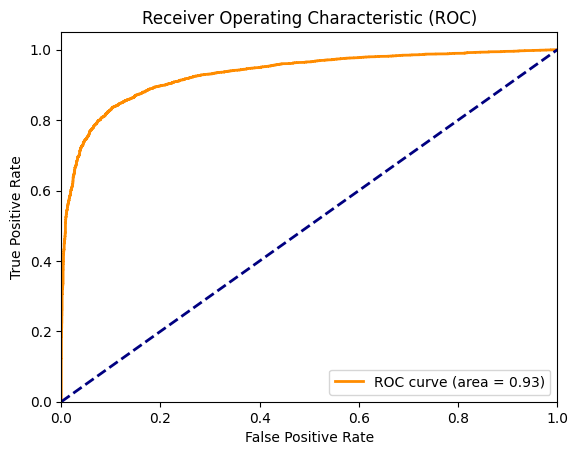

In [49]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()